In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')



## Find all our datasets

In [27]:
# read all csv in the data folder
data_path = os.path.join(os.getcwd(), 'data')
files = os.listdir(data_path)
files = [os.path.join(data_path, f) for f in files if f.endswith('.csv')]

## Checkout a specific datset

In [28]:
file = files[0]
print(f"reading file: {file}")
file_year = file.split('tripdata_')[1].split('-')[0]
file_month =file.split('tripdata_')[1].split('-')[1].split('.')[0]
print(file_year, file_month)

raw= pd.read_csv(file, index_col=0)

reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-01.csv
2019 01


In [29]:
raw.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
VendorID,,,,,,,,,,,,,,,,,
1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


There are some dates outside of the desired timeframe

In [30]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7667792 entries, 1 to 2
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   passenger_count        int64  
 3   trip_distance          float64
 4   RatecodeID             int64  
 5   store_and_fwd_flag     object 
 6   PULocationID           int64  
 7   DOLocationID           int64  
 8   payment_type           int64  
 9   fare_amount            float64
 10  extra                  float64
 11  mta_tax                float64
 12  tip_amount             float64
 13  tolls_amount           float64
 14  improvement_surcharge  float64
 15  total_amount           float64
 16  congestion_surcharge   float64
dtypes: float64(9), int64(5), object(3)
memory usage: 1.0+ GB


In [31]:
raw.isna().sum()

tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4855978
dtype: int64

## Data engineering

In [32]:
def clean_data(df: pd.DataFrame, year:int, month:int) -> pd.DataFrame:
    """Clean data by removing outliers and missing values."""
    df = df[df["passenger_count"]>0]
    df = df[df["trip_distance"]>0]
    df = df[df["fare_amount"]>0]
    df = df[df["total_amount"]>0]
    df = df[df["year"] == year]
    df = df[df["month"] == month]
    return df.reset_index()

def feature_eng(df: pd.DataFrame)-> pd.DataFrame:
    df = df.copy()
    """Create new features from existing ones.
    Transform datetime to datetime object.  
    Create new features for day of week, weekday, weeknr, hour of day, month and year."""
    
    # convert to datetime
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

    # create filtering features
    df = df.assign(day_of_week = df["tpep_pickup_datetime"].dt.dayofweek)
    df = df.assign(weekday = df["tpep_pickup_datetime"].dt.day_name())
    df = df.assign(weeknr = df["tpep_pickup_datetime"].dt.isocalendar().week)
    df = df.assign(hour_of_day = df["tpep_pickup_datetime"].dt.hour)
    df = df.assign(month = df["tpep_pickup_datetime"].dt.month)
    df = df.assign(year = df["tpep_pickup_datetime"].dt.year)
    df = df.sort_values(by="tpep_pickup_datetime")
    return df

In [33]:
df = raw.pipe(feature_eng).pipe(clean_data, year=int(file_year), month=int(file_month))

## Exploration

In [34]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'day_of_week', 'weekday',
       'weeknr', 'hour_of_day', 'month', 'year'],
      dtype='object')

In [35]:
df.tail(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,day_of_week,weekday,weeknr,hour_of_day,month,year
7490317,2,2019-01-31 23:59:46,2019-02-01 00:07:56,1,2.50,1,N,48,239,1,...,0.00,0.3,12.96,0.0,3,Thursday,5,23,1,2019
7490318,1,2019-01-31 23:59:47,2019-02-01 00:17:01,1,2.50,1,N,113,50,1,...,0.00,0.3,17.30,0.0,3,Thursday,5,23,1,2019
7490319,2,2019-01-31 23:59:47,2019-02-01 00:53:29,1,23.55,1,N,186,117,1,...,5.76,0.3,75.06,0.0,3,Thursday,5,23,1,2019
7490320,2,2019-01-31 23:59:47,2019-02-01 00:07:13,1,1.49,1,N,48,170,1,...,0.00,0.3,9.96,0.0,3,Thursday,5,23,1,2019
7490321,2,2019-01-31 23:59:48,2019-02-01 00:12:41,5,4.25,1,N,137,74,2,...,0.00,0.3,15.30,0.0,3,Thursday,5,23,1,2019
7490322,1,2019-01-31 23:59:49,2019-02-01 00:03:12,1,0.70,1,N,230,163,1,...,0.00,0.3,6.30,0.0,3,Thursday,5,23,1,2019
7490323,1,2019-01-31 23:59:49,2019-02-01 00:32:08,1,16.20,1,N,90,108,1,...,0.00,0.3,52.30,0.0,3,Thursday,5,23,1,2019
7490324,1,2019-01-31 23:59:51,2019-02-01 00:23:33,2,6.50,1,N,4,41,1,...,0.00,0.3,26.80,0.0,3,Thursday,5,23,1,2019
7490325,1,2019-01-31 23:59:51,2019-02-01 00:30:54,1,6.90,1,Y,158,7,1,...,0.00,0.3,32.15,0.0,3,Thursday,5,23,1,2019
7490326,2,2019-01-31 23:59:51,2019-02-01 00:28:56,6,11.23,1,N,125,247,1,...,0.00,0.3,42.36,0.0,3,Thursday,5,23,1,2019


Text(0.5, 0.98, 'Total amount and passengers on dates 01-2019')

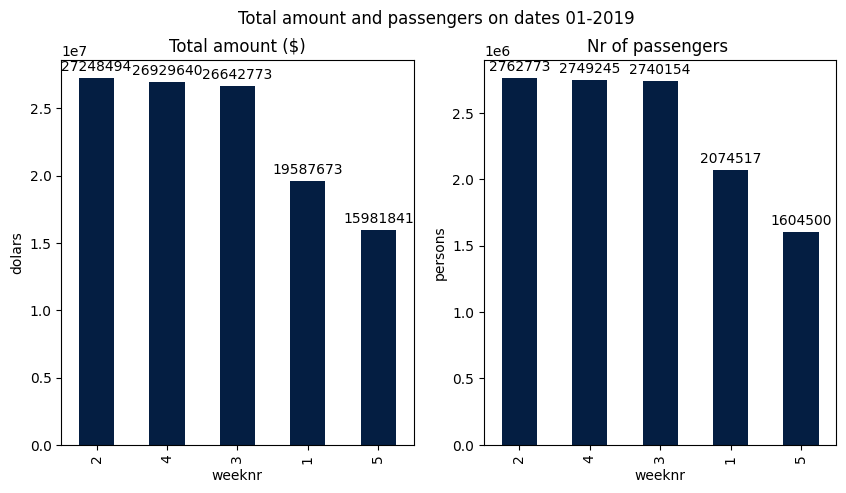

In [36]:
#monday= 0 sunday=6
fig, ax = plt.subplots(1,2,figsize=(10,5))
df.groupby(["weeknr"])["total_amount"].sum().sort_values(ascending=False).plot(kind="bar", color="#041E42", ax=ax[0])
ax[0].set_title(f"Total amount ($)")
ax[0].set_ylabel("dolars")
ax[0].bar_label(ax[0].containers[0], fmt='%.0f', padding=3)

df.groupby(["weeknr"])["passenger_count"].sum().sort_values(ascending=False).plot(kind="bar", color="#041E42", ax=ax[1])
ax[1].set_title(f"Nr of passengers ")
ax[1].set_ylabel("persons")
ax[1].bar_label(ax[1].containers[0], fmt='%.0f', padding=3)

plt.suptitle(f"Total amount and passengers on dates {file_month}-{file_year}")


Text(0, 0.5, 'dolars')

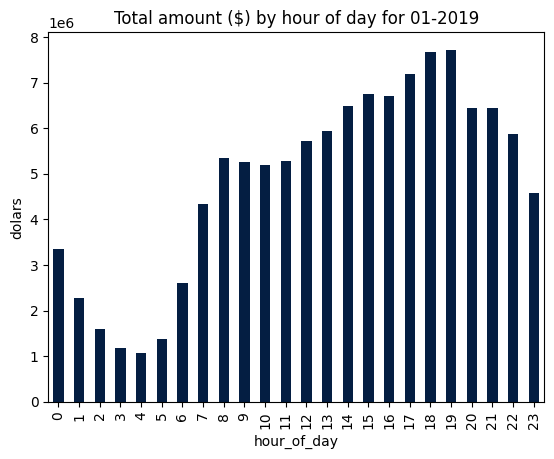

In [37]:
df.groupby("hour_of_day")["total_amount"].sum().plot(kind="bar", color="#041E42")
plt.title(f"Total amount ($) by hour of day for {file_month}-{file_year}")
plt.ylabel("dolars")


In [ ]:
#import test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(["total_amount"], axis=1), df["total_amount"], test_size=0.2, random_state=42)

Text(0.5, 0, 'miles')

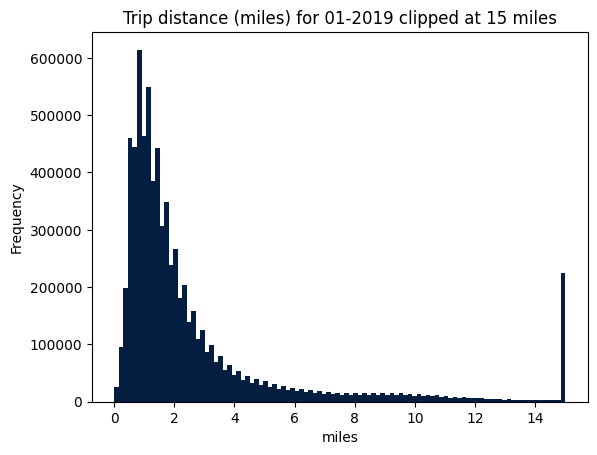

In [38]:
df["trip_distance"].clip(upper=15).plot(kind="hist", bins=100, color="#041E42")
plt.title(f"Trip distance (miles) for {file_month}-{file_year} clipped at 15 miles")
plt.xlabel("miles")

Text(0.5, 1.0, 'Payment type for 01-2019')

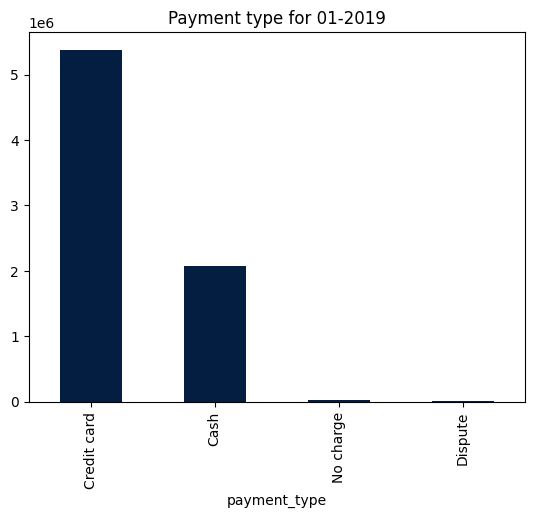

In [39]:
df["payment_type"].value_counts().plot(kind="bar", color="#041E42")
plt.xticks([0,1,2,3], ["Credit card", "Cash", "No charge", "Dispute"])
plt.title(f"Payment type for {file_month}-{file_year}")

### Drop from memory

# Modelling
We could try to predict 
- our income for the next month  
- Amount of taxis that will be needed in each area each day
- amount Taxi will earn for each trip or day


Try to use this info:
- Best places to pick passengers
- Best times of the day
- Amount of passengers I need to reach my goal

### Predict earnings per trip

In [42]:
X_cols= ["trip_distance", "passenger_count","PULocationID","DOLocationID", "RatecodeID", "hour_of_day", "day_of_week", "weeknr"]
y_cols= ["total_amount"]

Text(0.5, 1.0, 'Correlation plot for 01-2019')

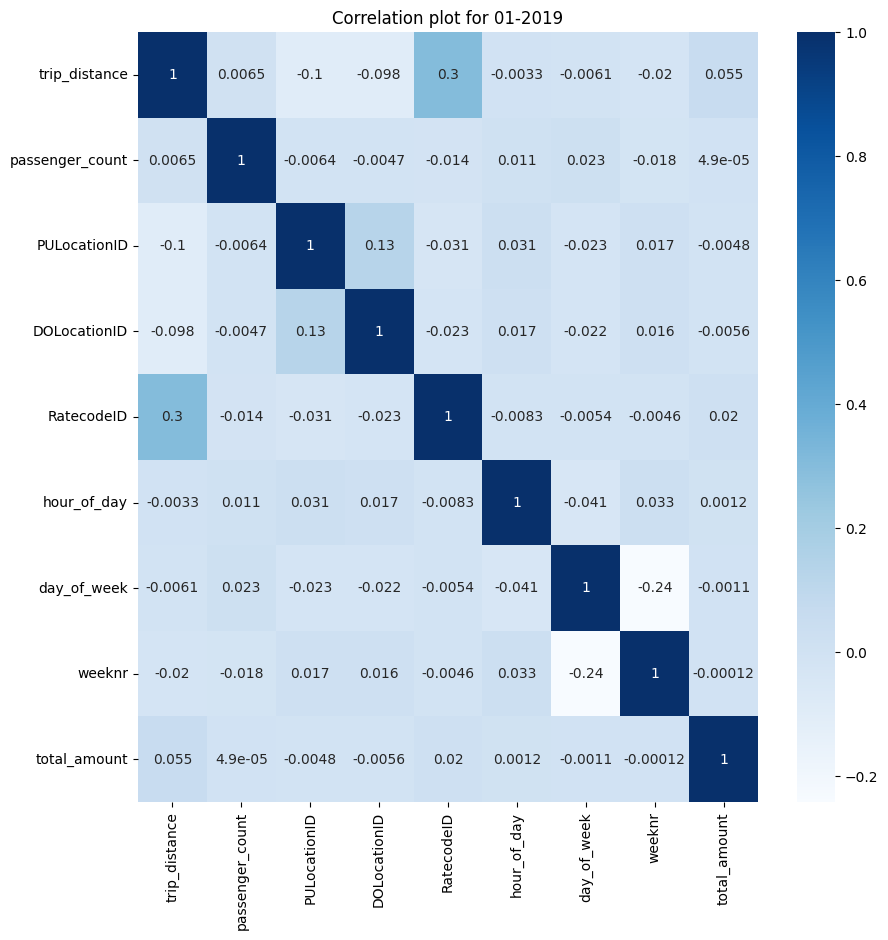

In [40]:
# simple corr plot for 1 year
corr = df[X_cols+y_cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title(f"Correlation plot for {file_month}-{file_year}")


In [41]:
#drop df and raw from memory
del df
del raw

### Train using 2019 data

In [43]:
# loop through our files that are from 2019, clean them, and drop all columns are not our selected features. Then concat them into one dataframe
test = pd.DataFrame()
for file in files:
    file_year = file.split('tripdata_')[1].split('-')[0]
    file_month =file.split('tripdata_')[1].split('-')[1].split('.')[0]
    if int(file_year) == 2019:
        print(f"reading file: {file},  used for training")
        raw= pd.read_csv(file, index_col=0)
        print(f"shape: {raw.shape}")
        _df = raw.pipe(feature_eng).pipe(clean_data, year=int(file_year), month=int(file_month))
        _df = _df[X_cols+y_cols]
        _df = _df.dropna()
        _df = _df.reset_index(drop=True)
        if file == files[0]:
            train = _df
        else:
            train = pd.concat([train, _df], axis=0)
    else:
        print(f"reading file: {file},used for testing")
        raw= pd.read_csv(file, index_col=0)
        print(f"shape: {raw.shape}")
        _df = raw.pipe(feature_eng).pipe(clean_data, year=int(file_year), month=int(file_month))
        _df = _df[X_cols+y_cols]
        _df = _df.dropna()
        _df = _df.reset_index(drop=True)
        test = pd.concat([test, _df], axis=0)
        

reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-01.csv,  used for training
shape: (7667792, 17)
reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-02.csv,  used for training
shape: (7019375, 17)
reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-03.csv,  used for training
shape: (7832545, 17)
reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-04.csv,  used for training
shape: (7433139, 17)
reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-05.csv,  used for training
shape: (7565261, 17)
reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-06.csv,  used for training
shape: (6941024, 17)
reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-07.csv,  used for training
shape: (6310419, 17)
reading file: d:\Python\General\scania\lambda-sagemaker\data\yellow_tripdata_2019-08.csv, 

In [53]:
# Persist train and test
train.to_parquet("train.parquet")
test.to_parquet("test.parquet")

### Use Xgboost

In [44]:
X_train = train[X_cols].values
y_train = train[y_cols].values.reshape(-1,1)

X_test = test[X_cols].values
y_test = test[y_cols].values.reshape(-1,1)

# scale our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Shapes of our data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


In [45]:
# For this example keep it simple
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, n_jobs=-1)

In [46]:
model = xgb_regressor.fit(X_train, y_train)

### Evaluate

In [47]:
y_pred = model.predict(X_test)

# calculate the mean absolute error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")

Mean squared error: 28174.169978425776
R2 score: 0.005764698345359531


### Result reflection
The results are terrible, clearly a lot of work would need to be done in the features and type of model used to predict this accurately  
But for the purpose of this example no effort has been put here more than a single training

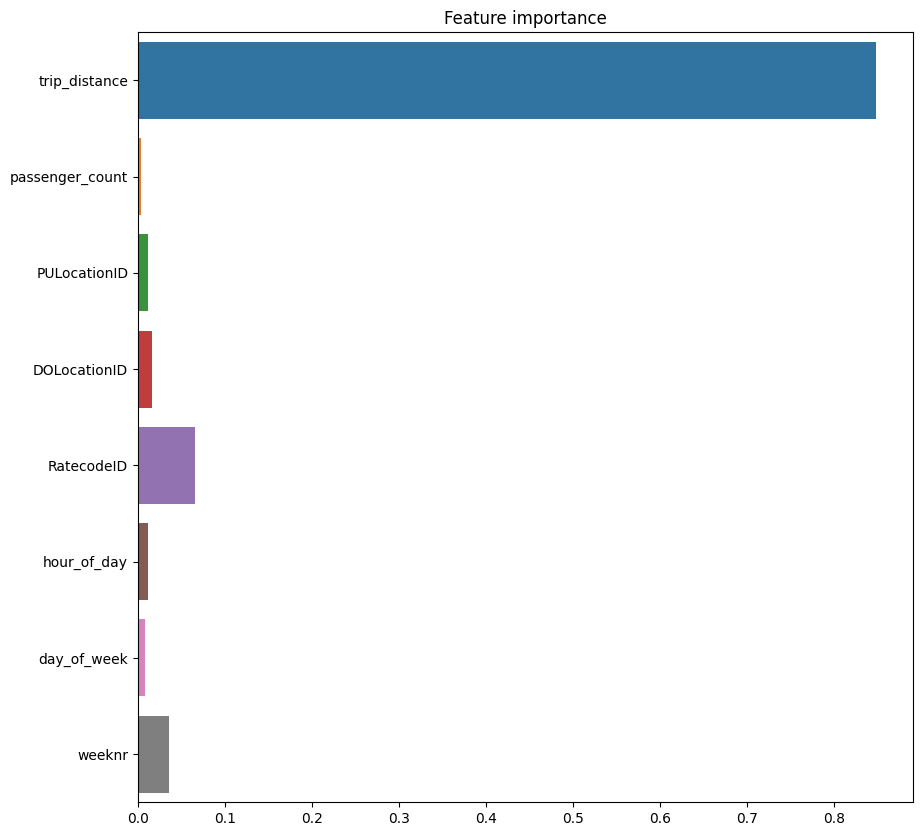

In [50]:
#feature importance sns
plt.figure(figsize=(10,10))
sns.barplot(x=model.feature_importances_, y=X_cols)
plt.title("Feature importance")
plt.show()


## Persist

In [51]:
# Persist model and scaler
joblib.dump(model, "./model/model.pkl")
joblib.dump(scaler, "./model/scaler.pkl")

['./model/scaler.pkl']